<a href="https://colab.research.google.com/github/wrightky/ANUGA_OnionCreek_Tutorial/blob/main/notebooks/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANUGA Lab

## CE377K - River Mechanics
### Kyle Wright
#### March 29-31, 2022

The goal of this Notebook is to give users an introduction to some of the basic functionality of the **ANUGA** hydrodynamic model. This model solves the 2D shallow-water equations on an **unstructured triangular grid**, and offers some key advantages over other models for modeling the hydrodynamics of Earth systems.

In this tutorial, we will build a simple, small, coarse model of the **Onion Creek Watershed**. Different cell blocks will demonstate how one can build the model mesh, initialize the domain, setup the parameters of the model, and run the simulation. 

The point of this script is not to build the best model we can of the domain, but rather to **demonstrate the workflow** of constructing a model that can be modified or replicated for other (better) models. 

These notebooks are written in Python 3, and have been designed to run in the Google `colaboratory` environment, which provides a Jupyter notebook environment running on a virtual machine on the cloud. Nothing needs to be installed locally, as it is entirely run on Google Drive. All you need is a Google account. All of these scripts are stored on GitHub, which is a platform for sharing open-source codes.

To start interacting with the notebook follow the `Open in Colab` link above. Once you're there, click `File` > `Save a Copy in Drive`

## Setup Environment

The first thing we have to do is set up our environment. In Python, this means downloading all the necessary functions we want to use, including ANUGA. 

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory. To run each code block, you can simply type `shift` + `enter`

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. The install should take less than a minute.

NOTE: Tutorial installation is based on the [2018 CSDMS Anuga Clinic](https://github.com/stoiver/anuga-clinic-2018)

In [43]:
# import shutil
# shutil.rmtree("ANUGA_OnionCreek_Tutorial")
# shutil.rmtree("anuga_core")

%cd ANUGA_OnionCreek_Tutorial/
!git pull
%cd ..

# !python /content/ANUGA_OnionCreek_Tutorial/anuga_tools/install.py > /dev/null 2>&1 

/content/ANUGA_OnionCreek_Tutorial
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/wrightky/ANUGA_OnionCreek_Tutorial
   10d57ed..0586a3a  main       -> origin/main
Updating 10d57ed..0586a3a
Fast-forward
 data/USGS_Onion183_metric.csv   | 60 -----------------------------------------
 data/USGS_Williamson_metric.csv | 60 -----------------------------------------
 2 files changed, 120 deletions(-)
/content


In [2]:
# Here we download/install all the files we need behind the scenes
try:
    import os
    os.chdir('/content')
    # Grab workbook files into colab directory
    !git clone https://github.com/wrightky/ANUGA_OnionCreek_Tutorial.git
    # Install everything
    !/bin/bash /content/ANUGA_OnionCreek_Tutorial/anuga_tools/install_anuga_colab.sh
    !python /content/ANUGA_OnionCreek_Tutorial/anuga_tools/install.py > /dev/null 2>&1 
    !cp ANUGA_OnionCreek_Tutorial/anuga_tools/shallow_water_domain.py anuga_core/anuga/shallow_water/
except:
  pass

# Deal with some directory stuff
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
import sys
sys.path.append(os.path.join(workbookDir,"ANUGA_OnionCreek_Tutorial"))
sys.path.append(os.path.join(workbookDir,"anuga_core"))

Cloning into 'ANUGA_OnionCreek_Tutorial'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 70 (delta 26), reused 56 (delta 17), pack-reused 0
Unpacking objects: 100% (70/70), done.
(1) Install pip packages
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
(5) Install anuga
(6) Ready to go


In [3]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import os
# import datetime
# from osgeo import gdal
import anuga
from anuga.utilities import animate
from anuga import Inlet_operator
from google.colab import files

%matplotlib inline

## Create ANUGA domain and mesh

In the following cell, we read in our model boundary polygon, and **instantiate the model domain and mesh** from that polygon. The internal mesh engine does almost all of the work for us here, we just need to feed it our **domain size**, desired **mesh resolution**, and any **interior polygons** we might want (if we have any). 

Interior polygons are one of the powerful features of ANUGA. We can have any number of regions inside our domain with their own mesh resolution. Is there an area you really care about and want to model in high-resolution? Easy. Is there an area you need to include but don't care a lot about, and can make very coarse to save computational time? Also easy. The only constraint is that the polygons defining the boundary those regions **can't overlap**.

For visualization, we will be making use of ANUGA's `animate.Domain_plotter` tool, which we initialize here and call repeatedly later.

Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Figure files for each frame will be stored in _plot
------------------------------------------------
Mesh statistics:
  Number of triangles = 17751
  Extent [m]:
    x in [6.22338e+05, 6.26983e+05]
    y in [3.33853e+06, 3.34113e+06]
  Areas [m^2]:
    A in [2.02307e+02, 6.24931e+02]
    number of distinct areas: 17751
    Histogram:
      [2.02307e+02, 2.44569e+02[: 92
      [2.44569e+02, 2.86832e+02[: 1305
      [2.86832e+02, 3.29094e+02[: 2893
      [3.29094e+02, 3.71357e+02[: 3191
      [3.71357e+02, 4.13619e+02[: 2749
      [4.13619e+02, 4.55881e+02[: 2364
      [4.55881e+02, 4.98144e+02[: 1904
      [4.98144e+02, 5.40406e+02[: 1559
      [5.40406e+02, 5.82668e+02[: 1056
      [5.82668e+02, 6.24931e+02]: 638
    Percentiles (10 percent):
      1775 triangles in [2.02307e+02, 2.93950e+02]
      1775 triangles in [2.93950e+02, 3.19167e+02]
      1775 triangles in [3.19167e+02, 3.426

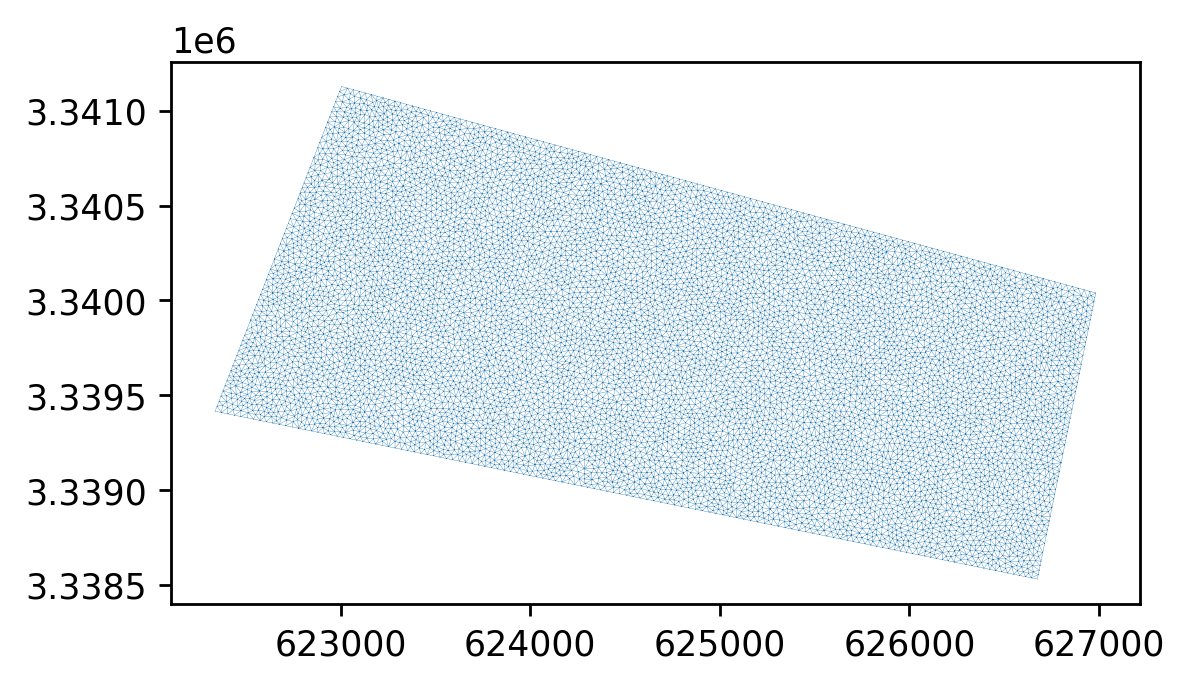

In [52]:
# ---------------Define Domain Boundary-----------------
bounding_polygon = [[622338.0, 3339415.0], [623005.0, 3341128.0],
                    [626983.0, 3340039.0], [626675.0, 3338530.0]]

# Assign a name to the different kinds of boundaries, needed for BCs later
boundary_tags={'sides': [0,1,3], 'downstream': [2]} # ID of segments, not points

# ---------------Define Geo Reference-------------------
geo_reference = anuga.Geo_reference(zone=14,
                                    datum='wgs84',
                                    projection='UTM',
                                    false_easting=500000,
                                    false_northing=0)

# Mesh Resolution (max area of triangles in each given region)
base_res = 625. # Areas we somewhat care about

# ---------------Generate domain and mesh---------------
domain = anuga.create_domain_from_regions(bounding_polygon, boundary_tags,
                                          maximum_triangle_area=base_res,
                                          mesh_geo_reference=geo_reference,
                                          mesh_filename = 'onion.msh')

# Comment out the interior region command to see what the mesh
# looks like without these features
# domain.set_name('OnionCreek')
# domain.set_flow_algorithm('DE1')
# domain.set_minimum_allowed_height(0.02)  # Only store heights > 2 cm

# Plot mesh
fig = plt.figure(figsize=(5, 5), dpi=250, facecolor='w', edgecolor='k')
dplotter = animate.Domain_plotter(domain)
plt.triplot(dplotter.triang, linewidth=0.1);
plt.axis('scaled')

# Print out some descriptive statistics of our mesh cells
print(domain.statistics())

## Create bathymetry/topography

Here we **populate** our new mesh with **topographic information** from an ASCII file. We started by converting from a GeoTIFF to an ASCII file (example command shown below using `gdal_translate`, here I just give you the ASCII directly). Then we do some additional conversions to get this into a filetype ANUGA can use (`.dem`, `.pts`). Finally, we use the resulting `.pts` file to create our model bathymetry.

These steps can be **quite slow** for fine meshes, so if the mesh isn't changing between runs, we recommend **saving the resulting topography** from the domain as a `.csv` and just re-loading that file for future runs. This file will be a long list of elevation values sorted by triangle ID.

*Note: The ASCII file needs to have the same headers as the file used here, which sometimes isn't the default. To repeat these steps, check the ASCII file with a text editor and make sure it has the same headers as the example ASCII files in th ANUGA examples folder. It also needs the accompanying `.prj` file!*

FitInterpolate: Building quad tree
Building smoothing matrix
Fit.fit: Initializing
Geospatial_data: Created from file: ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts
Data will be loaded blockwise on demand
Got 1 variables: ['elevation']
Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Default units is m.
ANUGA does not correct for differences in units.
Geospatial_data: Reading 2839074 points (in 3 block(s)) from file ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts. 
Geospatial_data: Each block consists of 1000000 data points

Geospatial_data: Reading block 0 (points 0 to 1000000) out of 2
. 
Geospatial_data: Reading block 1 (points 1000000 to 2000000) out of 2
. 
Geospatial_data: Reading block 2 (points 2000000 to 2839074) out of 2
. 
Fit.fit: Warning: no data points in fit
Applying fitted data to domain


(622105.75, 627215.25, 3338400.1, 3341257.900000001)

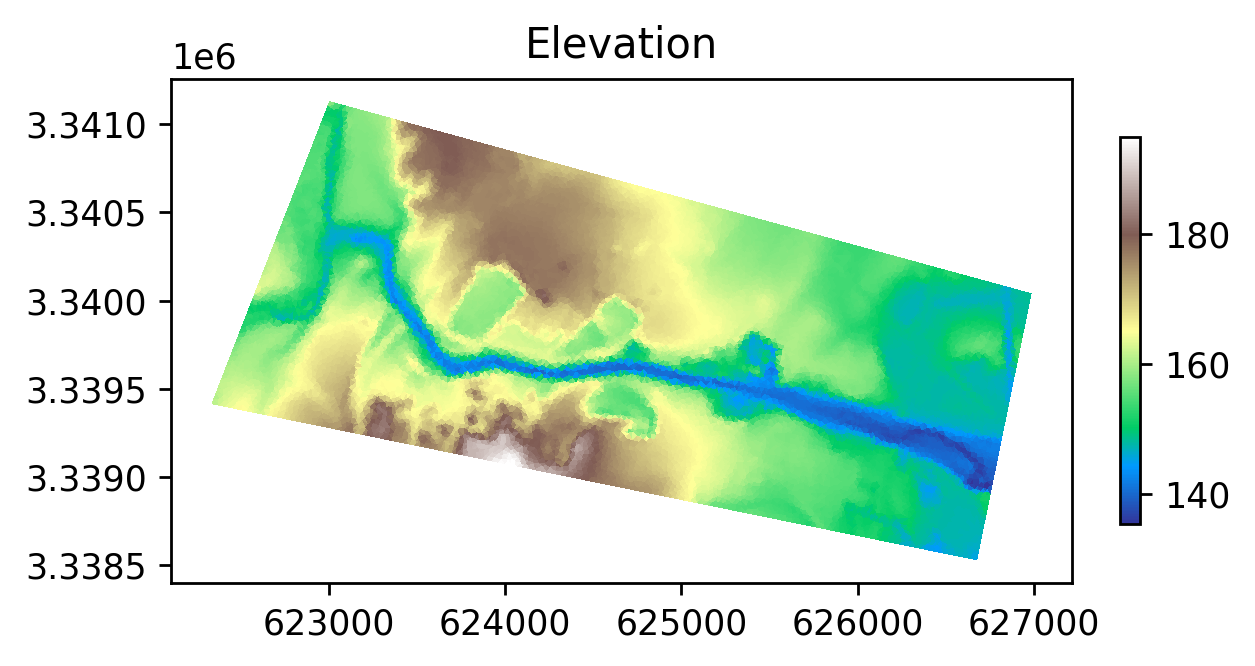

In [53]:
# If starting from a GeoTIFF, translate to ASCII:
# !gdal_translate -of AAIGrid bathy.tif bathy.asc
# ASCII to DEM conversion
# anuga.asc2dem('ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.asc',
#               use_cache=False, verbose=True)
# DEM to "points"
# anuga.dem2pts('ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.dem',
#               use_cache=False, verbose=True)
# Use "points" to populate mesh cells
domain.set_quantity('elevation', 
                    filename='ANUGA_OnionCreek_Tutorial/data/EG_OnionCreek_2m_EPSG_32614_m.pts',
                    use_cache=False,
                    verbose=True,
                    alpha=0.1)

# Plot topography
fig=plt.figure(figsize=(5, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors = dplotter.elev, cmap = 'terrain')
plt.colorbar(fraction=0.02);
plt.title("Elevation");
plt.axis('scaled')

# To save time next time, we can save the result
# topo = domain.quantities['elevation'].centroid_values
# np.savetxt('EG_OnionCreek_2m_EPSG_32614_m.csv', topo, delimiter=",")

## Add boundary conditions

Here we make use of some nearby USGS gauge data to presrcibe our model **boundary conditions**. Here we use two common types of BCs: **Dirichlet** and **Reflective**. In the case of the former, we tell the model exactly what the water surface elevation and/or velocities are along that boundary as a function of time. For the latter, the boundary acts like a solid wall, bouncing any flows back inside the domain. 

We assign our downstream boundary condition to match the water surface elevations of the nearby gauge using ANUGA's `Time_boundary` function, for which we specify [`stage`, `xmomentum`, `ymomentum`] as a function of time (only `stage` is set to vary here). All the other boundaries are designated as a no-flux `Reflective_boundary`, because we don't expect flows in those directions.

*Note: Due to poor boundary placement in relation to where these gauges are located, we've added a few fudge factors in the following sections for the purposes of this demonstration. Ideally, your boundaries should be drawn where you have a good sense for the mass balance of your system!*

In [54]:
# Load in gauge data
usgs_a = pd.read_csv('ANUGA_OnionCreek_Tutorial/data/USGS_Onion183_metric.csv',
                     header=0, names=['a','datetime','tz','Q','WL'])
usgs_a['datetime'] = pd.to_datetime(usgs_a['datetime']) # Convert to datetime dtype
# Need to convert datetimes into 'seconds from initial time'
usgs_a['epoch'] = (usgs_a['datetime'] - usgs_a['datetime'][0]) // pd.Timedelta("1s")

usgs_b = pd.read_csv('ANUGA_OnionCreek_Tutorial/data/USGS_Williamson_metric.csv',
                     header=0, names=['a','datetime','tz','Q','WL'])
usgs_b['datetime'] = pd.to_datetime(usgs_b['datetime']) # Convert to datetime dtype
# Need to convert datetimes into 'seconds from initial time'
usgs_b['epoch'] = (usgs_b['datetime'] - usgs_b['datetime'][0]) // pd.Timedelta("1s")

In [55]:
vert_offset = 1.0 # Vertical correction to gauge data
# Create a linear interpolation function for the WSE:
fBC_downstream = interp1d(usgs_a['epoch'], usgs_a['WL'] + vert_offset, kind='linear')

# Downstream boundary
Bout = anuga.Time_boundary(domain, function=lambda t: [fBC_downstream(t), 0.0, 0.0])

# All other boundaries
Br = anuga.Reflective_boundary(domain)

# Assign BCs to the boundaries we named earlier
domain.set_boundary({'downstream': Bout, 'sides': Br})

## Add discharge hydrograph

Here we define our **discharge**, and create an **inlet** through which that discharge is added to the model.

The way ANUGA handles discharge is somewhat odd compared to other models. Most models define a mass inflow as a boundary condition, and every time-step mass is added appropriately. Due to some weird quirks about how ANUGA's numerical solver handles BCs, it works better to add an **inlet** *inside the domain* through which water flows into our domain, somewhat like a flooding bath drain. (Note that **outlets** can be created the same way by specifying a **negative discharge**)

To make a static inlet with a steady discharge value, you add the inlet once and be done with it. Because we want our discharge to vary, we have to update the discharge later inside the loop when we run the model. We do this by modifying the `Q` attribute via `first_inlet.Q = new_value`.

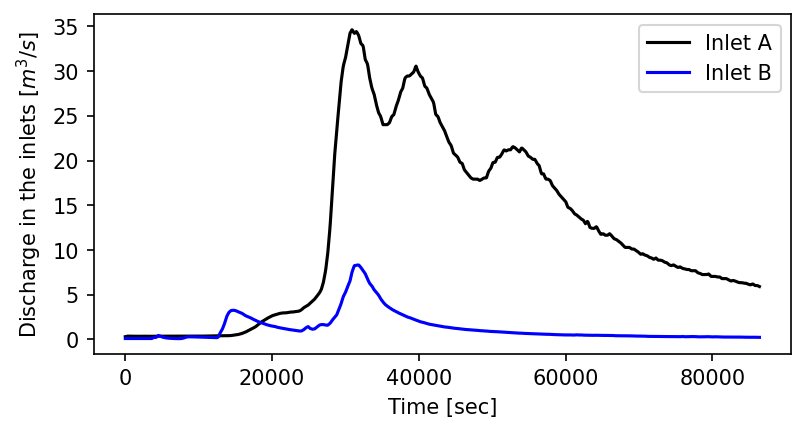

In [56]:
# Create two more interpolation functions for Q
# Changing arrival time & magnitude of gauge A to make up for poor BC placement
usgs_a['epoch_2'] = (usgs_a['datetime'] - usgs_a['datetime'][0] - pd.Timedelta('70 min')) // pd.Timedelta("1s")
fQ_a = interp1d(usgs_a['epoch_2'], usgs_a['Q']*0.8, kind='linear')
fQ_b = interp1d(usgs_b['epoch'], usgs_b['Q'], kind='linear')

# Setup inlets
first_inlet = np.array([[622627.,3339957.],[622627.,3339982.]]).astype('double') # Coordinates of line
first_inflow = Inlet_operator(domain, first_inlet, Q = fQ_a(0))

second_inlet = np.array([[623031,3341074],[623035,3341085]]).astype('double') # Coordinates of line
second_inflow = Inlet_operator(domain, second_inlet, Q = fQ_b(0))
# If these Q's were static, we would already be done

# Visualize time-varying Q
tt = np.linspace(0., 86400, 1000)
Qplta = [fQ_a(ti) for ti in tt]
Qpltb = [fQ_b(ti) for ti in tt]
plt.figure(figsize=(6,3), dpi=150)
plt.plot(tt, Qplta, 'k-')
plt.plot(tt, Qpltb, 'b-')
plt.xlabel('Time [sec]')
plt.ylabel('Discharge in the inlets [$m^3/s$]')
plt.legend(['Inlet A','Inlet B'])

## Add rainfall

Rainfall is added to the model domain at a defined rate (mm/s) over a specified period of time. For this simulation, we will add rainfall at **0.01 mm/s** for a duration of **2 hours**. The rainfall scheme specifed here must align with the simulation time to be defined later. We anticipate running a **6 hr simulation**, so let's say here that we will begin applying this rainfall to the domain after **1 hour** of simulation time. This will dump **7.2 cm (2.83 in.)** on the entire domain. This section is pretty simple -- we are only defining our rainfall intensity and timing. The real action occurs in the model simulation loop below.

*Note: There are many ways to define rainfall (and discharge) in ANUGA. If we were using a real storm event, we would probably have a `.csv` file with time-series data that we could read here, create an interpolation function similar to the one we established for wind, and feed in that function instead of this artificial one.*

Text(0, 0.5, 'Rainfall over the domain [$mm/s$]')

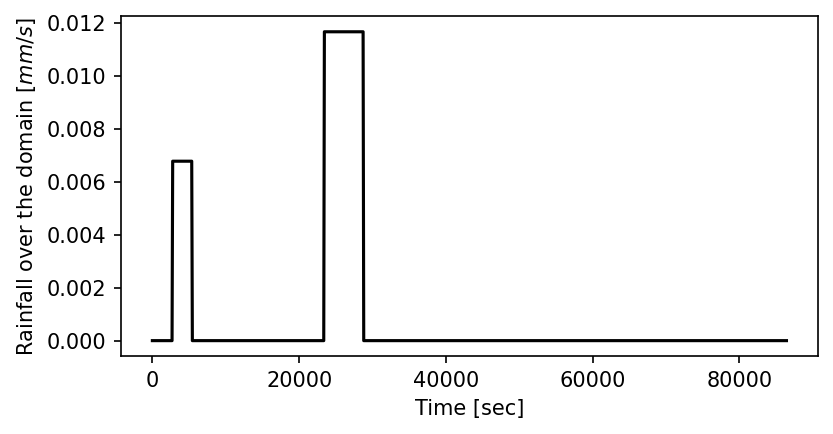

In [57]:
window1 = [2700, 5400]
window2 = [23400, 28800]
rain_rate_window1 = 0.006778 # mm/s
rain_rate_window2 = 0.011667 # mm/s

def rainfall(t):
  if window1[0] <= t < window1[1]:
    rate = rain_rate_window1
  elif window2[0] <= t < window2[1]:
    rate = rain_rate_window2
  else:
    rate = 0.
  return rate

# Append to forcing terms
R = anuga.Rainfall(domain, rate=rainfall)
domain.forcing_terms.append(R)

# Visualize time-varying R
tt = np.linspace(0., 86400, 1000)
RR = [rainfall(ti) for ti in tt]
plt.figure(figsize=(6,3), dpi=150)
plt.plot(tt, RR, 'k-')
plt.xlabel('Time [sec]')
plt.ylabel('Rainfall over the domain [$mm/s$]')

## Final touches for initial conditions

Here we initialize the **stage**, as well as Manning's coefficients for the non-vegetated areas of the landscape (channels, the bay). We could have used a dry bed as our initial condition, but this will help the model reach a stable condition more quickly. This run is what we would call a **cold start**, because the model is pretty much starting from scratch with an uninformative initial condition. Ideally, for future runs, we would use the saved output of this run as our new IC, because a **hot start** will always converge more quickly.

In [58]:
# ---------------Load pre-established elevation----------------------
topo = domain.quantities['elevation'].centroid_values
stage = topo.copy()  # Initialize stage as = topography
stage[topo <= fBC_downstream(0)] = fBC_downstream(0) # Used for cold start
domain.set_quantity('stage', stage, location='centroids')  # Initialize depth

# Note that if we had initial conditions from a prior run, we could use those:
# domain.set_quantity('xmomentum', init_xmom, location='centroids')
# domain.set_quantity('ymomentum', init_ymom, location='centroids')

# Use Manning's
friction = np.ones_like(topo)*0.05
domain.set_quantity('friction', friction, location = 'centroids')

## Run the model

Here we call on `domain.evolve()` to **run the model** for a specified amount of time. We **save information** on the model's converved quantities (`xmomentum`, `ymomentum`, `stage`) into the output file every `yieldstep`, here set to every **900 seconds** (15 minutes). This **isn't the same thing as the *timestep***: the actual timesteps the model takes are decided by ANUGA based on **stability conditions**, which depends on the spacing of the mesh, speed of the flow, and other numerical mumbo-jumbo. We use the command `domain.print_timestepping_statistics()` to tell us some summary statistics of these timesteps every `yieldstep`.

This loop also enables us to **make changes to our model** as time progresses, if we wish. In this example, we update discharge and wind speed (if turned on) within the evolve loop. To do this, we simply modify the attributes of the discharge and wind objects we created earlier. For each of these functions, we use the value _centered_ in each time window between this yieldstep and the next (i.e. `t + savefreq`). Notice that we do not have to modify the tide or rainfall forcings here -- those were defined using functions of time, so they are automatically updated every time-step. 

In [59]:
# ------------------------------------------------------------------------------
# Evolve system through time
# ------------------------------------------------------------------------------
savefreq = 3600.
simtime = savefreq*24.

for n, t in enumerate(domain.evolve(yieldstep=savefreq, finaltime=simtime)):
    # Print out some statistics on the model evolution
    domain.print_timestepping_statistics()

    # -------------Define discharge for current yield step---------------
    first_inflow.Q = fQ_a(t+savefreq)
    second_inflow.Q = fQ_b(t+savefreq)

Time = 0.0000 (sec), steps=0 (64s)
Time = 3600.0000 (sec), delta t in [1.20621341, 1.56903429] (s), steps=2297 (25s)
Time = 7200.0000 (sec), delta t in [1.40467031, 1.56734987] (s), steps=2371 (36s)
Time = 10800.0000 (sec), delta t in [1.30560437, 1.40465999] (s), steps=2672 (39s)
Time = 14400.0000 (sec), delta t in [1.28154905, 1.30559276] (s), steps=2792 (42s)
Time = 18000.0000 (sec), delta t in [1.17071270, 1.28154854] (s), steps=2946 (43s)
Time = 21600.0000 (sec), delta t in [0.85702208, 1.17068526] (s), steps=3478 (51s)
Time = 25200.0000 (sec), delta t in [0.80072692, 0.85694133] (s), steps=4361 (66s)
Time = 28800.0000 (sec), delta t in [0.64081422, 0.80072345] (s), steps=4960 (75s)
Time = 32400.0000 (sec), delta t in [0.56041520, 0.64073796] (s), steps=6243 (92s)
Time = 36000.0000 (sec), delta t in [0.55751771, 0.56631123] (s), steps=6420 (93s)
Time = 39600.0000 (sec), delta t in [0.56564362, 0.56877421] (s), steps=6346 (92s)
Time = 43200.0000 (sec), delta t in [0.56528879, 0.574

## Inspect outputs

Here, we introduce a few ways one can query the resulting output file. All of ANUGA's results are saved in a **NetCDF** file with the extension `.sww`. These can be loaded using any normal NetCDF reader, but ANUGA also comes pre-packaged with several functions for inspecting your model results, most of which are stored in `anuga.utilities.plot_utils`

In [60]:
# Load in values of conserved quantities at every cell centroid
swwvals = anuga.utilities.plot_utils.get_centroids('domain.sww', timeSlices='all')
# Query values: time, x, y, stage, elev, height, xmom, ymom, xvel, yvel, friction, vel, etc
model_starttime = pd.to_datetime('2022-03-21 17:00:00')

# Separate variables just for accessibility
time = swwvals.time
topo = swwvals.elev
x = swwvals.x
y = swwvals.y
depth = swwvals.height
stage = swwvals.stage
u = swwvals.xvel
v = swwvals.yvel
w = np.sqrt(u**2 + v**2)

(622105.75, 627215.25, 3338400.0999999996, 3341257.9)

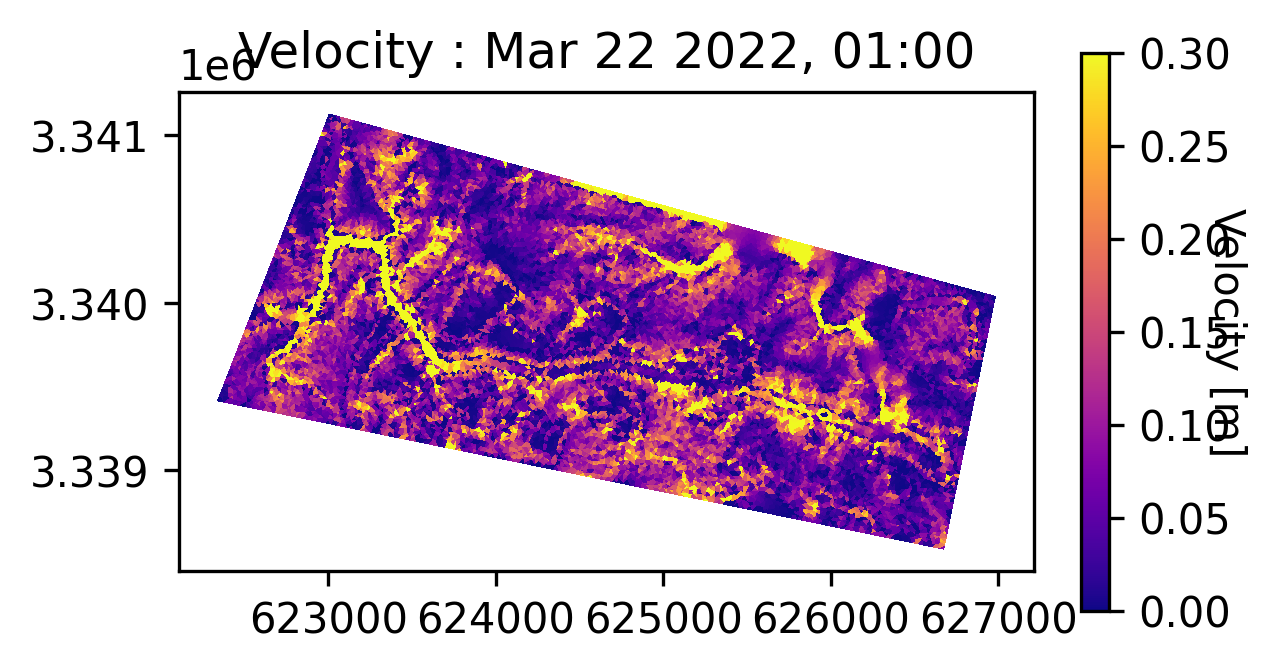

In [79]:
# ------------------------------------------------------------------------------
# Plot a single map of velocity at centroids
# ------------------------------------------------------------------------------
# Time index to plot:
time_idx = 8

timeUTC = pd.to_timedelta(time[time_idx], 's') + model_starttime
fig = plt.figure(figsize=(4, 4), dpi=300, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=w[time_idx,:], 
              vmax=0.3, vmin=0, cmap='plasma')
cbar = plt.colorbar(fraction=0.03);
cbar.set_label('Velocity [m]', rotation=270)
plt.title('Velocity : ' + timeUTC.strftime("%b %d %Y, %H:%M"));
plt.axis('scaled')

(622105.75, 627215.25, 3338400.1, 3341257.9)

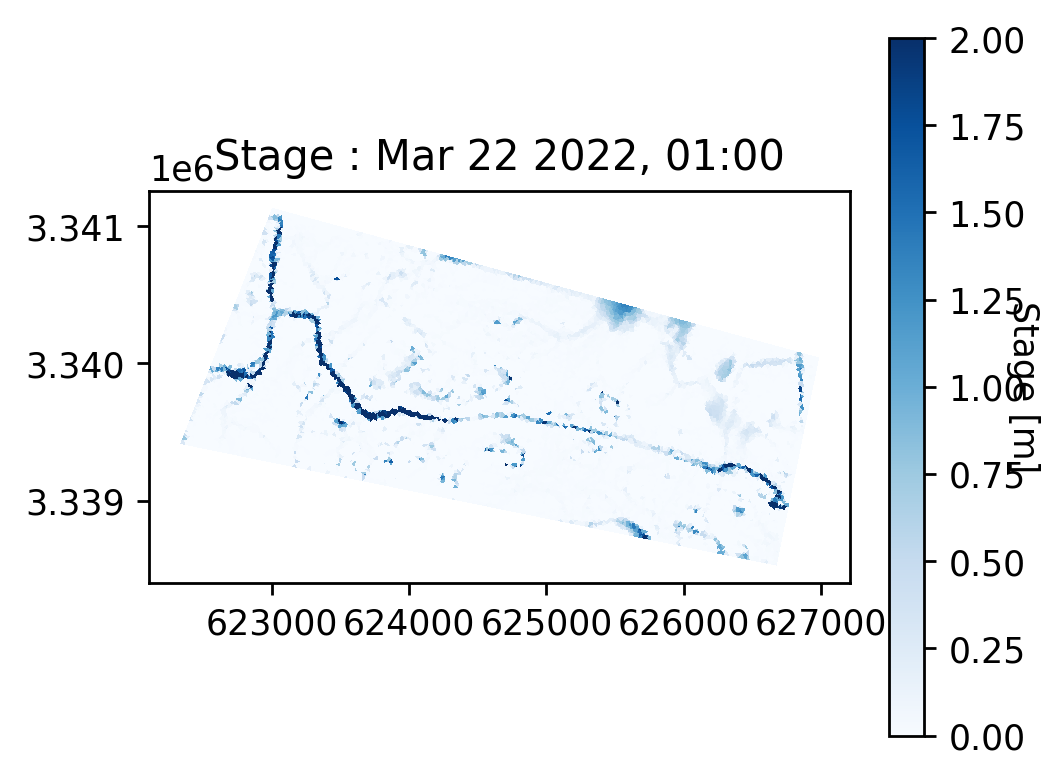

In [86]:
# ------------------------------------------------------------------------------
# Plot a single map of stage at centroids
# ------------------------------------------------------------------------------
# Time index to plot:
time_idx = 8

timeUTC = pd.to_timedelta(time[time_idx], 's') + model_starttime
fig = plt.figure(figsize=(4, 4), dpi=250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=depth[time_idx,:],
              vmin=0, vmax=2, cmap='Blues')
cbar = plt.colorbar(fraction=0.045);
cbar.set_label('Stage [m]', rotation=270)
plt.title('Stage : ' + timeUTC.strftime("%b %d %Y, %H:%M"));
plt.axis('scaled')

(622105.75, 627215.25, 3338400.1, 3341257.9)

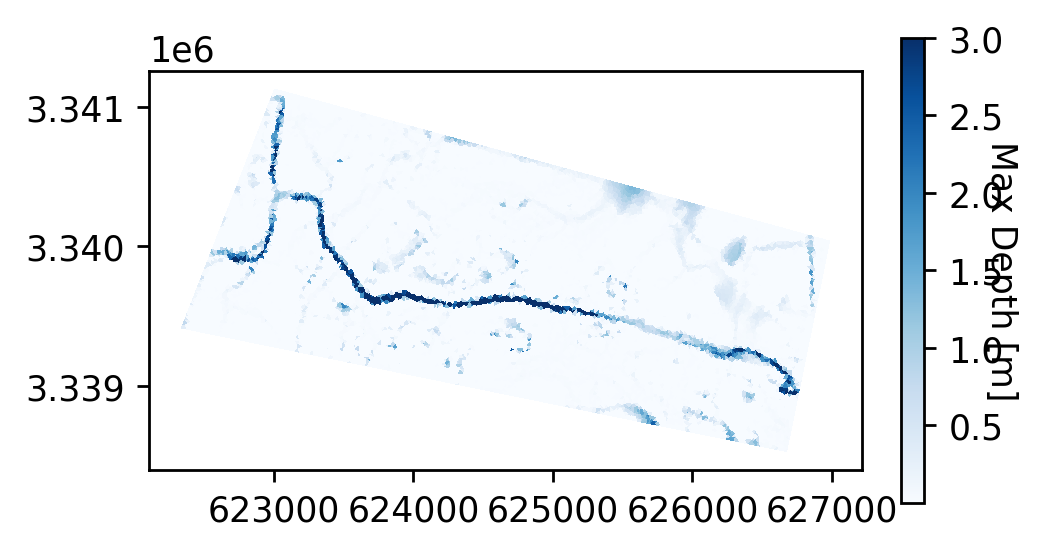

In [89]:
fig = plt.figure(figsize=(4, 4), dpi=250, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=np.nanmax(depth,axis=0), cmap='Blues', vmax=3)
cbar = plt.colorbar(fraction=0.03);
cbar.set_label('Max Depth [m]', rotation=270)
plt.axis('scaled')

In [ ]:
# ------------------------------------------------------------------------------
# Plot time-series at a gauge location
# ------------------------------------------------------------------------------
# Create triangle lookup function to find cell index of a gauge
p = anuga.utilities.plot_utils.get_output('WLD.sww')
tri_lookup = anuga.utilities.plot_utils.get_triangle_lookup_function(p)

# Create time vector of model outputs
model_timeseries = model_starttime + pd.to_timedelta(time, 's')

# Find coordinates of gauge and cell containing it, extract stage
xx, yy = [650620.941, 3265354.835]
idx = tri_lookup(xx, yy)
gaugestage = stage[:, idx]

fig = plt.figure(figsize=(5, 3), dpi=150, facecolor='w', edgecolor='k')
plt.plot(model_timeseries, gaugestage, 'k--')
plt.ylabel('Stage [m NAVD88]')